In [1]:
%load_ext autoreload
%autoreload 2
from storytelling import *

In [71]:
word_embeddings = LoadWordEmbeddings(fil="../dat/glove/glove.twitter.27B.100d.txt")

In [118]:
#datfile = "../dat/4884.csv.gz"
datfile = "../dat/wildfire_yosemite.csv"
df = pd.read_csv(datfile)
df.shape

(5314, 12)

In [119]:
# Keep original tweet, rm retweet
df = df[df["rt_id"].isna()]
print(df.shape)

(3582, 12)


In [121]:
df1 = df[df["user_followers_count"]>10**4]
df1 = df1.reset_index()
df1.shape

(504, 13)

In [122]:
DC = TwitterCleaner()
urlsearch = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
ALL_Sentences = []
Clean_sentences = []
for i,row in df1.iterrows():
    #Data.append(DC.Clean(df1.loc[i, "text"]))
    sentence = df1.loc[i, "text"].strip("\n")
    sentence = re.sub(r'RT\s@[\w]*', '', sentence)
    sentence = re.sub(r'MT\s@[\w]*', '', sentence)
    sentence = re.sub(r'@[\w]*', '', sentence)
    sentence = re.sub(r'#[\w]*', '', sentence)
    sentence = re.sub(r'&amp;', 'and', sentence)
    sentence = re.sub(urlsearch, '', sentence)
    #sentence = re.sub(r'[^\w\s]', ' ', sentence)
    sentence = sentence.strip()
    sentences = re.split('; |, ',sentence)
    new_sentences = []
    for s in sentences:
        if "..." in s:
            continue
        new_sentences.append(s)
    sentence = "".join(new_sentences)
    if sentence == "":
        continue
    ALL_Sentences.append(sentence)
    Clean_sentences.append(" ".join(DC.Clean(sentence)))

In [123]:
#for l in ALL_Sentences:
#    print(l)

In [124]:
sentence_vectors = Sentence2WE(Clean_sentences, word_embeddings)

In [125]:
sim_mat = TextRankScoreMat(sentence_vectors)

In [126]:
sim_mat

array([[0.        , 0.74944069, 0.74302168, ..., 0.64616579, 0.60603065,
        0.64616579],
       [0.74944069, 0.        , 0.87957088, ..., 0.80656976, 0.83357853,
        0.80656976],
       [0.74302168, 0.87957088, 0.        , ..., 0.75292348, 0.81199876,
        0.75292348],
       ...,
       [0.64616579, 0.80656976, 0.75292348, ..., 0.        , 0.83881187,
        1.        ],
       [0.60603065, 0.83357853, 0.81199876, ..., 0.83881187, 0.        ,
        0.83881187],
       [0.64616579, 0.80656976, 0.75292348, ..., 1.        , 0.83881187,
        0.        ]])

In [127]:
threashold = 0.9
rm_idx = []
kept_idx = []
for i in range(sim_mat.shape[0]):
    if i in rm_idx:
        continue
    kept_idx.append(i)
    for j in range(sim_mat.shape[1]):
        if sim_mat[i,j]>threashold:
            rm_idx.append(j)   
print(len(kept_idx))

128


In [133]:
art = []
selected_Clean = []
for i in kept_idx:
    art.append(ALL_Sentences[i])
    selected_Clean.append(Clean_sentences[i])
    #print(i, ALL_Sentences[i])
out = open("Yosemite.psodu.txt", 'wt')
out.write(" ".join(art))

8442

In [134]:
sentence_vectors = Sentence2WE(selected_Clean, word_embeddings)
sim_mat = TextRankScoreMat(sentence_vectors)

In [143]:
sentence_vectors[0].shape

(100,)

In [135]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [137]:
#ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(Clean_sentences)), reverse=True)
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(art)), reverse=True)
rank_art = []
for i in range(10):
    print(ranked_sentences[i][1])

NOW AT 11: Wildfire near Yosemite has more than tripled in sizew/ 2,500 buildings threatened by flames. WATCH LIVE:
Visitors flee as wildfire bears down on Yosemite - USA TODAY
ABC News reports wildfire near Yosemite now the size of Sacramento.
Wildfire spreads to Yosemite National Parkthreatens homes. Read more:
: Wildfire near Yosemite National Park threatens 2,500 homeshotels and camp buildings
Update on  :  Fire near  spreads to over 53,866 acres
Massive California Wildfire Creeps Into Yosemite National Park. .
San Francisco water supply safe for now despite massive wildfire burning near Hetch Hetchy.
GRAPHIC: The California wildfire burning on the mountain rims of the Stanislaus National Forest has entered Yosemite:
A wildfire is burning out of control near Yosemite.


In [139]:
rank_arts = []
for score, text in ranked_sentences:
    #print(s,j)
    rank_arts.append(text)

In [140]:
out = open("Yosemite.psodu.txt", 'wt')
out.write(" ".join(rank_arts))

8442

In [144]:
sentence_vectors = np.array(sentence_vectors)
sentence_vectors.shape

(128, 100)

(128, 40)


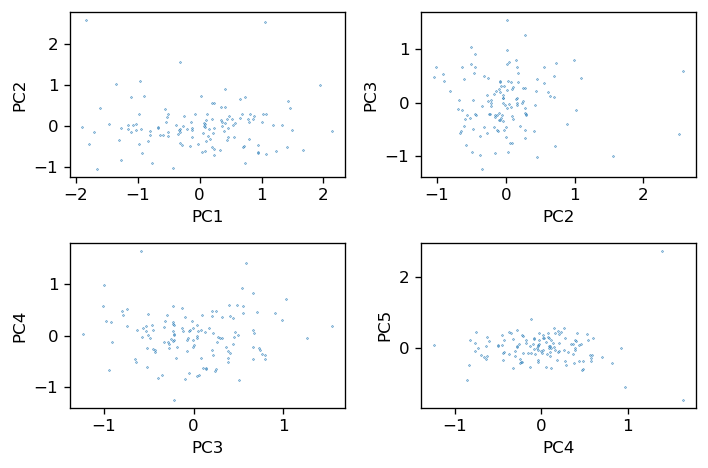

In [146]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(sentence_vectors)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()

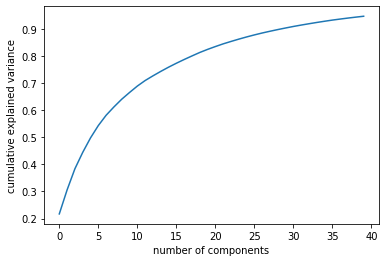

In [147]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [148]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :40])

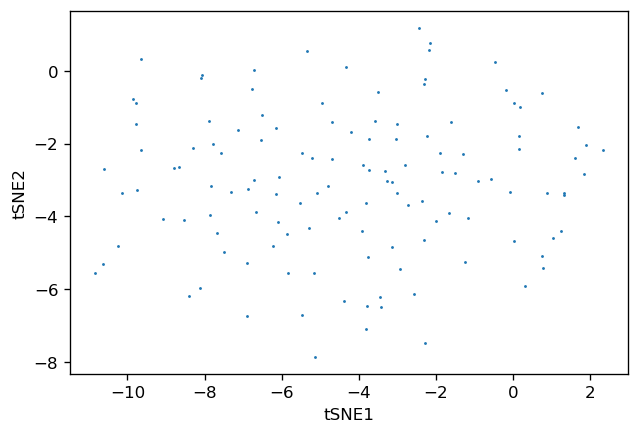

In [149]:
fig = plt.figure(dpi=120)
ax = plt.subplot(111)
ax.scatter(Y[:,0], Y[:,1],s=0.5)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.show()